## Init

In [1]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path+'/src')
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\new-peak-project\src


In [2]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


In [3]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

## Data Preparation

In [4]:
from scripts.matlab.load_time_course_data import load_timecourse_data
from scripts.matlab.load_target_data import load_target_data

In [5]:
file_path = f'{config["DATA_PATH"]}/matlab_output/ground_truth_data.csv'
import pandas as pd 
simulation_data = pd.read_csv(file_path, index_col=0)

In [6]:
feature_data_file_path = f'notebooks/tests/shared_dir/src/feature_data.pkl'
import pickle
with open(feature_data_file_path, 'rb') as f:
    feature_data = pickle.load(f)

In [7]:
ground_time_course_data = load_timecourse_data(simulation_data, index_option='cell_id')
target_data = load_target_data(simulation_data, 'pERK', index_option='cell_id')

In [8]:
all_species = list(ground_time_course_data.columns)
# remove 'pERK' from all_species
all_species.remove('pERK')

In [9]:
from models.Utils import last_time_point_method, dynamic_features_method

last_time_data = last_time_point_method(ground_time_course_data, all_species)
dynamic_data = dynamic_features_method(ground_time_course_data, all_species, n_cores=8)


In [10]:
combined_lp_data = pd.concat([feature_data, last_time_data], axis=1)
combined_dyn_data = pd.concat([feature_data, dynamic_data], axis=1)


In [11]:
feature_data_list = [feature_data, last_time_data, dynamic_data, combined_lp_data, combined_dyn_data]
feature_data_names = ['feature_data', 'last_time_data', 'dynamic_data', 'combined_lp_data', 'combined_dyn_data']

In [12]:
o_random_seed = 42
target_name = 'pERK'

## Machine Learning 

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np

def build_pipeline(model, scale=False):
    steps = [('imputer', SimpleImputer(strategy='mean'))]
    if scale:
        steps.append(('scaler', StandardScaler()))
    steps.append(('model', model))
    return Pipeline(steps)



def evaluate_model(model, model_name, feature_data, feature_data_name, target_data, test_size=0.2, random_state=4):
    # Align rows between X and y
    common_idx = feature_data.index.intersection(target_data.index)
    X = feature_data.loc[common_idx]
    y = target_data.loc[common_idx]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return {
        'Model': model_name, 
        'Feature Data': feature_data_name,
        'Mean Squared Error': mean_squared_error(y_test, y_pred),
        'R2 Score': r2_score(y_test, y_pred),
        'Pearson Correlation': pearsonr(y_test, y_pred)[0],
        'Pearson P-Value': pearsonr(y_test, y_pred)[1]
    }

all_models = [
    build_pipeline(LinearRegression()),
    build_pipeline(RandomForestRegressor(n_estimators=100, random_state=o_random_seed)),
    build_pipeline(GradientBoostingRegressor(n_estimators=100, random_state=o_random_seed)),
    build_pipeline(SVR(max_iter=10000), scale=True),
    build_pipeline(MLPRegressor(hidden_layer_sizes=(20,), max_iter=10000, random_state=o_random_seed), scale=True)
]

all_models_desc = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Support Vector Machine', 'Neural Network']
zipped_model_data = list(zip(all_models, all_models_desc))
all_features = feature_data_list
all_features_desc = feature_data_names
zipped_feature_data = list(zip(all_features, all_features_desc))

# random states are rand ints between 0 and 10000, for n values 
np.random.seed(o_random_seed)
n_random = 10
all_random_states = np.random.randint(0, 10000, n_random)

parallelise = True 
from tqdm import tqdm
# tqdm is a progress bar library, use it to show the progress of the model evaluation
metric_data = []
if not parallelise:          
    for (feature_data, feature_data_name) in tqdm(zipped_feature_data):
        # print('Feature Data:', feature_data_name)
        # print('Feature Data Shape:', feature_data.shape)
        for (model, model_name) in zipped_model_data:
            # print('Model:', model_name)
            for rand in all_random_states:
                metrics = evaluate_model(model, model_name, feature_data, feature_data_name, target_data[target_name], random_state=rand)
                metric_data.append(metrics)
                
else:        
    # parallelise the model evaluation process using joblib
    from joblib import Parallel, delayed

    metric_data = Parallel(n_jobs=-1)(delayed(evaluate_model)(model, model_name, feature_data, feature_data_name, target_data[target_name], random_state=rand) 
                                    for (feature_data, feature_data_name) in zipped_feature_data
                                    for (model, model_name) in zipped_model_data
                                    for rand in all_random_states)

# make a dataframe of the metric data
metric_df = pd.DataFrame(metric_data)
metric_df

,Model,Feature Data,Mean Squared Error,R2 Score,Pearson Correlation,Pearson P-Value
0,Linear Regression,feature_data,3.010706e+07,0.645668,0.808963,3.996814e-13
1,Linear Regression,feature_data,2.978134e+07,0.685539,0.876160,1.813371e-17
2,Linear Regression,feature_data,2.489395e+07,0.391084,0.709902,3.794150e-09
3,Linear Regression,feature_data,2.309846e+07,0.476354,0.712514,3.133166e-09
4,Linear Regression,feature_data,2.857129e+07,0.721367,0.903340,5.147987e-20
...,...,...,...,...,...,...
245,Neural Network,combined_dyn_data,8.098186e+07,0.159380,0.716288,2.367472e-09
246,Neural Network,combined_dyn_data,1.246606e+07,0.722317,0.853151,9.677025e-16
247,Neural Network,combined_dyn_data,5.671809e+07,-0.336121,0.894041,4.571165e-19
248,Neural Network,combined_dyn_data,1.062061e+07,0.732289,0.888405,1.559564e-18


## Visualisation

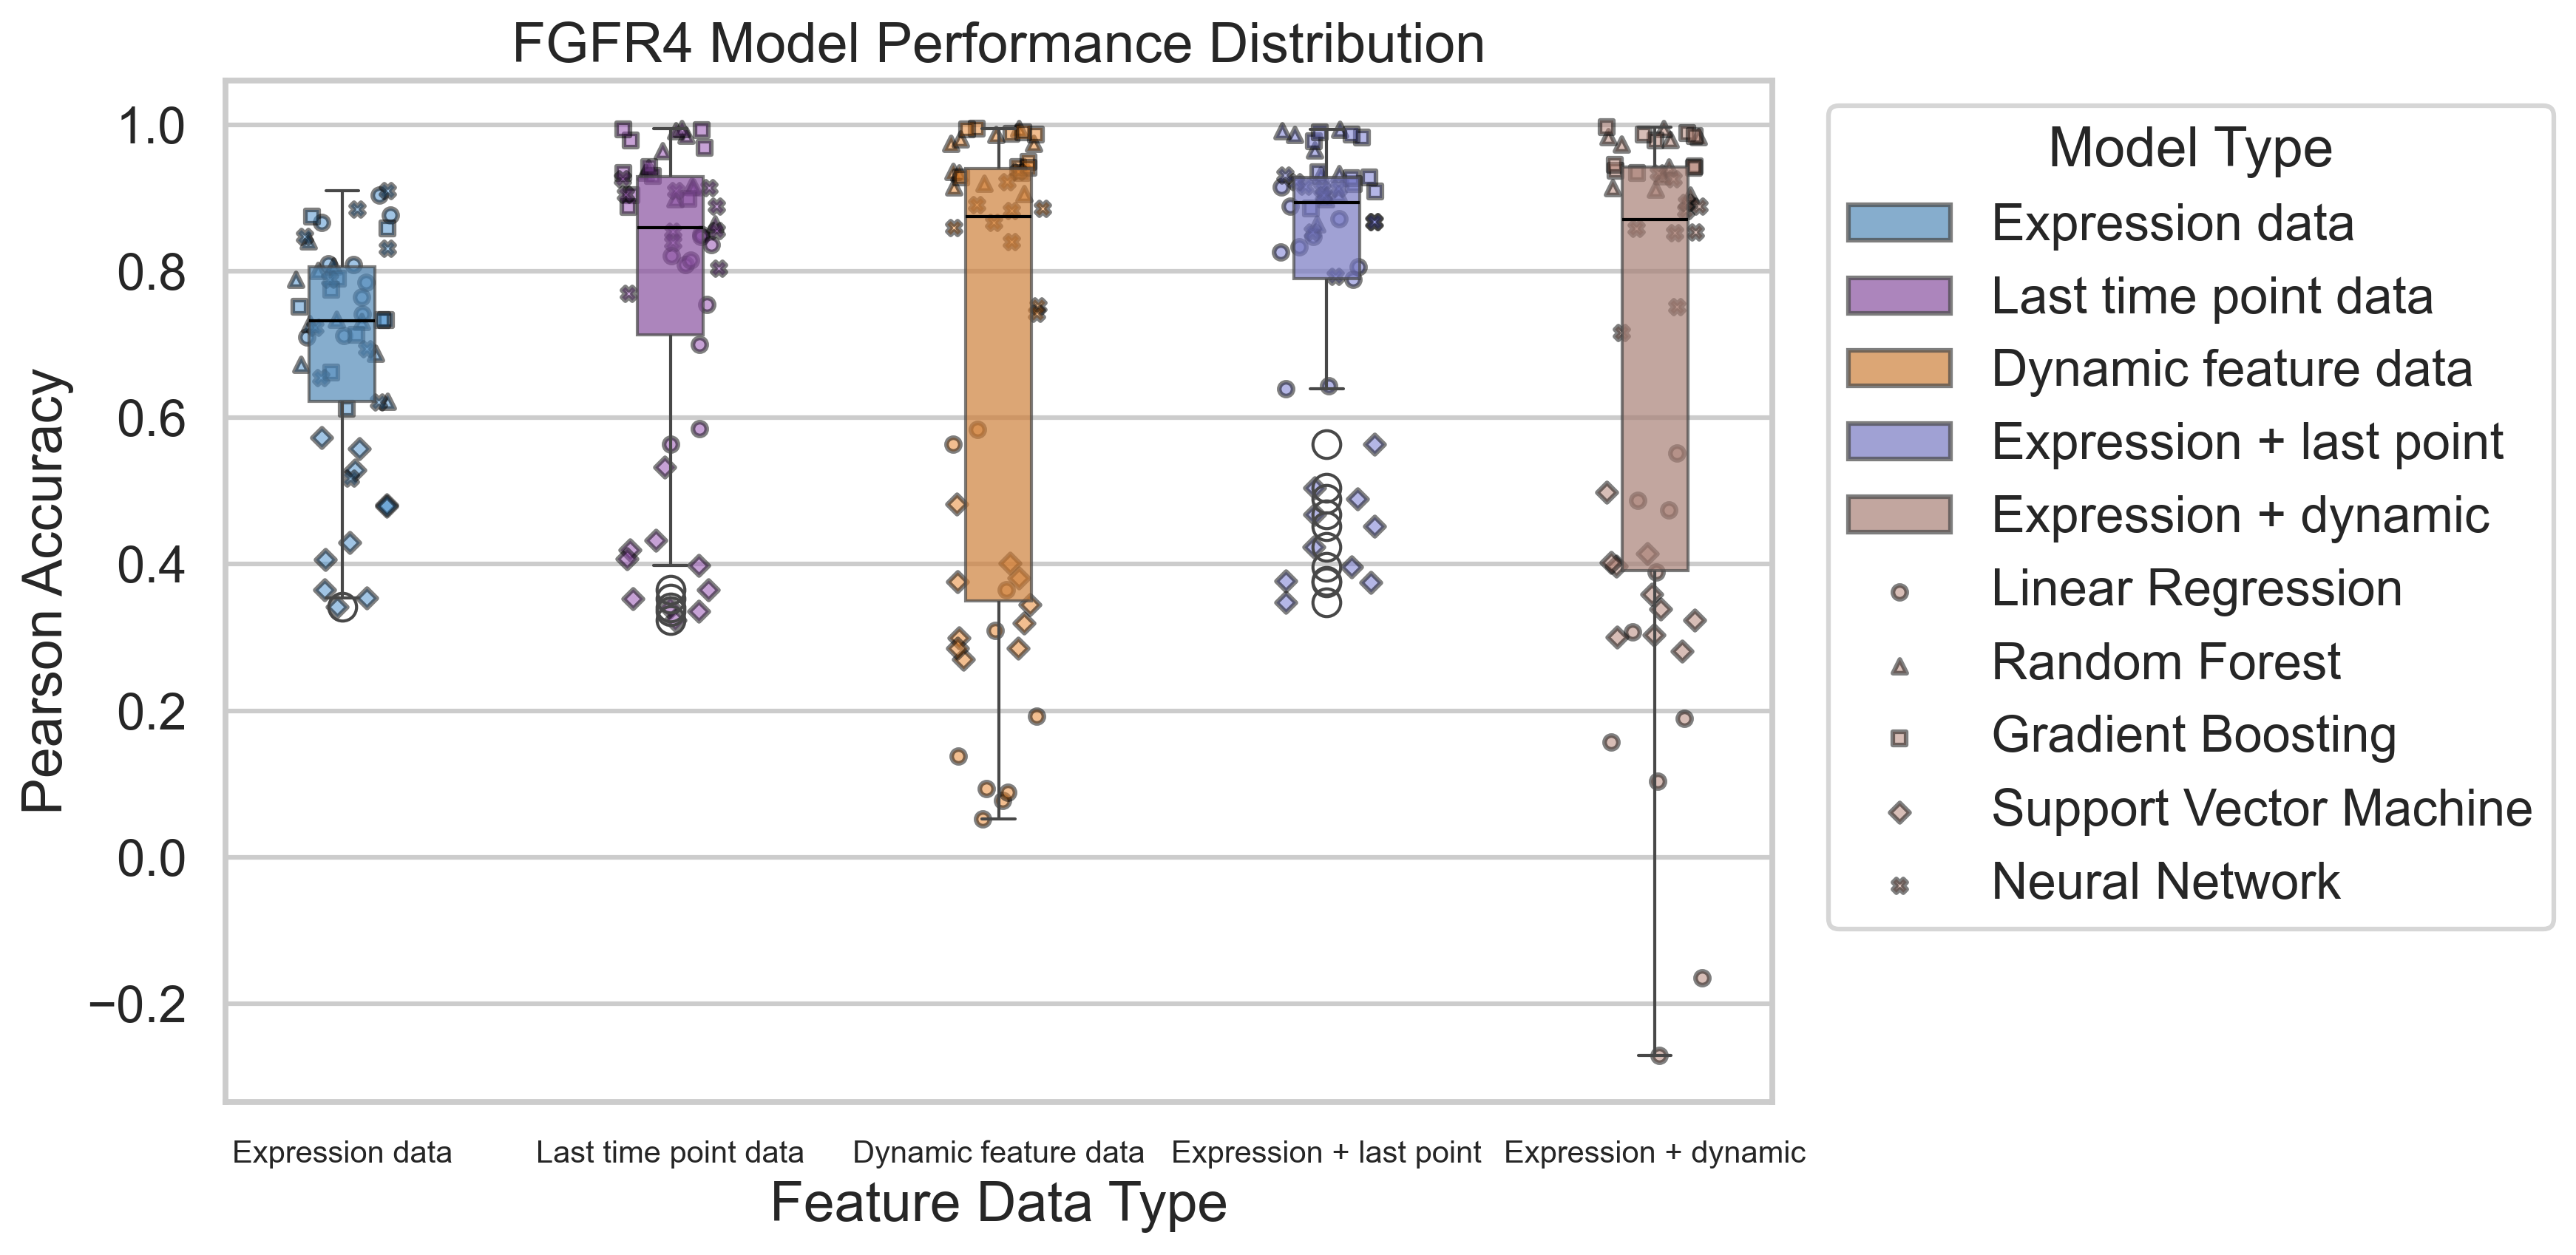

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import numpy as np

# Define custom markers for each model
model_markers = {
    'Linear Regression': 'o',
    'Random Forest': '^',
    'Gradient Boosting': 's',
    'Support Vector Machine': 'D',
    'Neural Network': 'X'
}

# Color map for feature data types
color_map = {
    'Expression data': '#428bca',
    'Last time point data': '#8e44ad',
    'Dynamic feature data': '#e67e22',
    'Expression + last point': '#6b6fcf',
    'Expression + dynamic': '#b07c6f'
}

# Preprocess data
plot_data = metric_df.copy()
plot_data['Feature Data'] = plot_data['Feature Data'].replace({
    'feature_data': 'Expression data',
    'last_time_data': 'Last time point data',
    'dynamic_data': 'Dynamic feature data',
    'combined_lp_data': 'Expression + last point',
    'combined_dyn_data': 'Expression + dynamic',
    'combined expression + last time point': 'Expression + last point',
    'combined expression + dynamic feature': 'Expression + dynamic'
})


# Get consistent order for feature types
feature_order = list(color_map.keys())

# Plot setup
plt.figure(figsize=(12, 6), dpi=300)
sns.set_context("talk", font_scale=1)
sns.set_style("whitegrid")
matplotlib.rcParams['font.family'] = 'Arial'

# Boxplot
ax = sns.boxplot(
    data=plot_data,
    x='Feature Data',
    y='Pearson Correlation',
    hue='Feature Data',            # Explicitly assign hue
    palette=color_map,
    width=0.2,
    showcaps=True,
    boxprops={'alpha': 0.7},
    medianprops={'color': 'black'},
    legend=True                   # Suppress duplicate legend
)

# Overlay points with custom markers per model
x_positions = {cat: i for i, cat in enumerate(feature_order)}

for model_name, marker in model_markers.items():
    subset = plot_data[plot_data['Model'] == model_name]
    for _, row in subset.iterrows():
        x = x_positions[row['Feature Data']] + np.random.uniform(-0.15, 0.15)
        y = row['Pearson Correlation']
        ax.scatter(x, y,
                   color=color_map[row['Feature Data']],
                   marker=marker,
                   s=20,
                   edgecolor='black',
                   alpha=0.5,
                   label=model_name)

# De-duplicate model legend
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), title="Model Type", bbox_to_anchor=(1.02, 1), loc='upper left')

# Axis styling
plt.title('FGFR4 Model Performance Distribution')
plt.xlabel('Feature Data Type')
plt.ylabel('Pearson Accuracy')
plt.xticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()
